<font color='red'> Если нет необходимых библиотек инсталируем их </font>

In [1]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
import torchvision.datasets
import torchvision.transforms as torch_T
from PIL import Image
import seaborn as sns
import gc
gc.enable()

# Лабораторная №1

In [2]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [4]:
X_train = X_train.float().numpy()

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
x = [1, 2, 3, 4]
np.array(map(lambda x: x[0] * x[1], list(enumerate(x))))

array(<map object at 0x7f93404c1d10>, dtype=object)

# Выбор варианта

Всего 60000 картинок, каждый выбирает картинки из диапазона $[6000(n-1)+1,6000\cdot n]$ где $n$- номер по списку.
Постройте гистограмму для ответов (y_train) и убедитесь, что у вас нет дисбаланса классов. Если есть дисбаланс, устраните его удалением соответствующего класса или удалением картинок. Порог для преобразования в $\{0,1\}$(см. ниже) установите равным:
$$
thr = 0.45 + (n-1)/100
$$

## Преобразуем данные в нули и единицы.

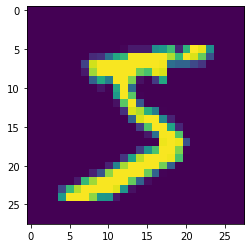

In [7]:
plt.imshow(X_train[0, :, :])
plt.show()

In [8]:
thr = 0.45 # Номер варианта см. список группы
X_train[X_train>thr] = 1
X_train[X_train<thr] = 0

## Картинка после преобразования

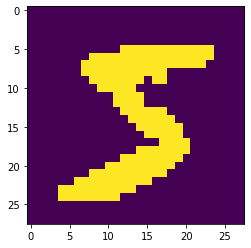

tensor(5)


In [9]:
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

## Применим EM-алгоритм для смеси распределений Бернулли

Найти выражения для E-шага и M-шага для смеси C штук распределений
Бернулли 
$$
p(X\mid \theta) = \prod_{i=1}^D \sum_{c=1}^C p (x_i|\mu_c)\pi_c, \quad x_i\in \mathbf{R}^N,  \quad \mu\in\mathbf{R}^N
$$
$$
p(z\mid\mu_c) = \prod_{j=1}^N \mu_{cj}^{z_j}(1-\mu_{cj})^{1-z_j}, \quad  z_j\in\{0,1\},
$$

где параметры модели $\theta = \{\mu_{11},\dots,\mu_{1N},\dots,\mu_{C1},\dots,\mu_{CN}, \pi_1,\dots, \pi_C\}$. 

<font color='red'> В отличие от модели на семинаре здесь параметр $\mu$ это вектор размера $N$ !!! </font>

## Задание 1: получить выражения для E-шага


Получить формулы для E-шага. 
$$
q(t_i) = p (t_i\mid x_i,\theta)
$$
$$
\gamma_{i,c} = q(t_i=c) = \dots
$$


<b>Важный трюк 1:</b> при вычислении произведений, можно использовать логарифмирование, при этом, чтобы избежать нулей под логарифмом, можно нули заменять на очень маленькие числа. 

<b>Важный трюк 2:</b> важно избегать числовых ошибок. В какой-то момент вам может понадобиться вычислить формулу следующего вида (если использовать логарифмирование (см. трюк 1)): $\frac{e^{y_i}}{\sum_j e^{y_j}}$, которая называется _softmax_. Когда вы вычисляете показатели степени больших чисел, некоторые числа могут стать бесконечными. Этого можно избежать, разделив числитель и знаменатель на $e^{\max(y)}$: 
$$
\frac{e^{y_i-\max(y)}}{\sum_j e^{y_j - \max(y) )}}.
$$ 
После этого преобразования максимальное значение в знаменателе будет равно единице. Все остальные члены будут вносить меньшие значения. Итак, чтобы вычислить нужную формулу, вы сначала вычитаете максимальное значение из каждой компоненты в векторе $\mathbf{y}$, а затем вычисляете все остальное, как и раньше.


## Задание 2: реализовать E-шаг

In [10]:


def E_step(X, pi, mu):       
    eps = 1e-12
    def G_c_i(xi, pc, mc):
        return xi @ np.log(mc + eps) + (1 - xi) @ np.log(1 + eps - mc) + np.log(pc + eps)

    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (D x N), data points
    pi: (C), mixture component weights 
    mu: (C x N), mixture component means
    
    Returns:
    gamma: (C x D), probabilities of clusters for objects
    """
    D = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    N = mu.shape[1] # dimension of each object
    gamma = np.zeros((C, D)) # distribution q(T)
    log_g = np.zeros((C, D))
    M = np.array([-1e6] * D)

    print('\tDefine log(g_c_i)')
    log_g = np.array(list(map(lambda c: np.array(list(map(lambda x: G_c_i(x, pi[c[0]], mu[c[0]]), X))), list(enumerate(log_g)))))
    gc.collect()
    for c in range(C):
        M = np.array(list(map(lambda x: x[1] if x[1] >= log_g[c][x[0]] else log_g[c][x[0]], list(enumerate(M))))) 
    gc.collect()

    print('\tDefine gamma')

    gamma = gamma.T
    for i in range(D):
        gamma[i] = np.exp(log_g.T[i] - M[i])
        gamma[i] = gamma[i] / (gamma[i].sum() +  eps)

    gc.collect()
    
    #TO DO
    return gamma.T

## Задание 3:  получить выражения для M-шаг


$$
{\cal L}(\theta,q) = \sum_i\sum_c \gamma_{i,c}\left(\sum_{j=1}^N x_{ij}\log(\mu_{cj}) + (1-x_{ij})\log(1-\mu_{cj})+ \log\pi_c\right) \to \max_{\theta}
$$

Составить функцию Лагранжа и получить выражения для $\theta$.

## Задание 4: реализовать M-шаг

In [11]:
np.array([1]).sum()

1

In [12]:
def M_step(X, gamma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (D x N), data points
    gamma: (C x D), probabilities of clusters for objects
    Returns:
    pi: (C)
    mu: (C x N)
    """
    D = X.shape[0] # number of objects
    C = gamma.shape[0] # number of clusters
    N = X.shape[1] # dimension of each object
    eps = 1e-12
    #TO DO
    pi = np.zeros(C)
    mu = np.zeros((C, N))
    # for c in range(C):
    #     pi[c] = gamma[c].sum() / (gamma.sum() + eps)
    #     for j in range(N):
    #         mu[c][j] = (gamma[c] @  X.T[j]) / (gamma[c].sum() + eps)
    g_summ = (gamma.sum() + eps)
    for c in range(C):
        g_c_summ = gamma[c].sum()
        pi[c] = g_c_summ / g_summ
        for j in range(N):
            mu[c][j] = (gamma[c] @  X.T[j]) / (g_c_summ + eps)
    
    gc.collect()
    return pi, mu

## Задание 5: получить функцию потерь

Наконец, нам нужна функция для отслеживания сходимости. Для этой цели мы будем использовать вариационную нижнюю границу $\mathcal{L}$. Мы остановим наши итерации EM, когда $\mathcal{L}$ перестанет сильно изменяться.  Также полезно проверить, что эта функция никогда не уменьшается во время тренировки. Если это так, у вас есть ошибка в вашем коде.

<b>Реализуем функцию, которая будет вычислять $\mathcal{L}$</b> 

$$\mathcal{L}(\theta, q) =\mathbb{E}_{q(T)}\log \frac{p(X,T | \theta)}{q(T|\theta)}  =  \dots$$ 

## Задание 6: реализовать функцию потерь

Не забываем использовать <b>трюк 1</b>.


$$
{\cal L}(\theta,q) = \sum_c\sum_i \gamma_{c,i}\left(\sum_{j=1}^N x_{ij}\log(\mu_{cj}) + (1-x_{ij})\log(1-\mu_{cj})\right)+ \log\pi_c \to \max_{\theta}
$$



In [13]:
def compute_vlb(X, pi, mu, gamma):
    """
    Each input is numpy array:
    X: (D x N), data points
    gamma: (C x D), distribution q(T)  
    pi: (C)
    mu: (C x N)
    sigma: (C x N x N)
    
    Returns value of variational lower bound
    """
    D = X.shape[0] # number of objects
    C = gamma.shape[0] # number of clusters
    N = X.shape[1] # dimension of each object
    eps =1e-9
    #TO DO

    # loss = 0
    # for c in range(C):
    #     for i in range(D):
    #         sum_ = 0
    #         for j in range(N):
    #             sum_ += X[i][j] * np.log(mu[c][j] + eps) + (1 - X[i][j]) * np.log(1 - mu[c][j] + eps)

    #         loss += sum_+ np.log(pi[c] + eps)

    loss = 0
    for c in range(C):
        for i in range(D):
            loss += X[i] @ np.log(mu[c] + eps) + (1 - X[i]) @ np.log(1 - eps + mu[c]) + np.log(pi[c] + eps)


    gc.collect()

    return loss

## Задание 7: внедрение процедуры обучения

Теперь, когда у нас есть шаг E, шаг M и VLB, мы можем реализовать тренировочный цикл. Мы будем инициализировать значения $\pi$, $\mu$ и $\Sigma$ некоторыми случайными числами, обучать до тех пор, пока $\mathcal{L}$ не перестанет меняться, и возвращать полученные точки. Мы также знаем, что алгоритм EM сходится к локальным оптимумам. Чтобы найти лучшие локальные оптимумы, мы перезапустим алгоритм несколько раз с разных (случайных) начальных позиций. Каждое тренировочное испытание должно останавливаться либо при достижении максимального количества итераций, либо когда относительное улучшение становится меньше заданного допуска $$\left|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal {L}_{i-1}}\right| \le \text{rtol}$$.

<b>Начальные данные:</b>
Параметры $\pi_c$ можно задавать одинаковыми, при это не забываем, что сумма равна единице.  Параметры $\mu$ можно моделировать равномерно на отрезке [0.25, 0.75], далее их надо отнормировать.

Также в код можно добавить обработку ситуации, когда целевая функция возвращает nan.

In [14]:
def rand_pi(C):
    pi = np.zeros(C)
    #TO DO
    return pi

def rand_mu(X, C, N):
    #print('\n', type(X), '\n', type(C), '\n', type(N))
    mu = np.ones((C,N))
    mu = np.abs(np.random.normal(size=(C, N)))
    mu /= mu.sum()
    # TO DO
    return mu


def train_EM(X, C=10, rtol=1e-3, max_iter=10, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (D, N), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    print(N, '\n', d)
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None
    loss_prev = None
    losses = []
    
    

    for _ in range(restarts):
        print('New restart')
        loss = None
        curr_rel_loss = None
        pic = np.abs(np.random.normal(size=C))
        pi0 = pic / pic.sum()
        mu0 = rand_mu(X, C, d) 
        loss = None
        for i in range(max_iter):
            gc.collect()
            pi, mu = pi0, mu0
            print('\nRun E - step')
            gamma = E_step(X, pi, mu)
            print('Run M - step')
            pi, mu  = M_step(X, gamma)
            print('Define Loss')
            loss = compute_vlb(X, pi, mu, gamma)
            print(f'Loss {loss:.2f}\n')
            losses.append(loss)
            pi0 = pi
            mu0 = mu
            if loss_prev != None:
                curr_rel_loss = np.abs(loss_prev - loss)/np.abs(loss_prev)
                loss_prev = loss
            else:
                loss_prev = loss
            if curr_rel_loss!=None and curr_rel_loss < rtol:
                break
            print(f'Step: {i}')
        if best_loss!=None:
            if loss>best_loss:
                best_loss = loss
                best_mu = mu
                best_pi = pi
        else:
            best_loss = loss
            best_mu = mu
            best_pi = pi

    return  losses, best_pi, best_mu

In [15]:
%%time
#losses, pi, mu = train_EM(np.array([X_train.reshape(-1, 28*28)[0]]), restarts= 2)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


In [16]:
#plt.imshow(mu[0].reshape(28,28))

## Задание 8

Обучить модель и ответить на следующие вопросы.

1. Построить графики для всех математических ожиданий в виде цифр (т.е. преобразовать вектора в матрицы) Похожи ли получившиеся средние на цифры? (С=10)
2. Построить несколько картинок для цифр из обучающей выборки и соответствующих математических ожиданий на одном графике для одного класса. Проделать это для нескольких классов. Как можно интерпретировать результат?
3. Разбить на обучающую и тестовую выборки, и определить оптимальное кол-во кластеров с помощью графиков правдоподобия для обучения и теста. 
4. Попробовать улучшить результат (варьировать различные параметры), подумать как оценивать качество.
5. Написать вывод.


In [17]:
n = 3
thr = 0.45 + (n - 1) / 100 # Номер варианта см. список группы
X_train_var = X_train[6000*(n-1): 6000*n]
Y_train_var = y_train[6000*(n-1): 6000*n]
X_train_var.shape

(6000, 28, 28)

In [18]:
X_train_var[X_train_var > thr] = 1
X_train_var[X_train_var < thr] = 0

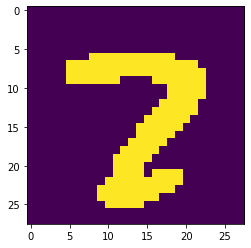

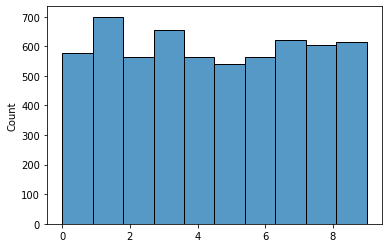

In [19]:
plt.imshow(X_train_var[0])
plt.show()
sns.histplot(Y_train_var, bins = 10)

In [20]:
X_train_var.reshape(-1, 28*28).shape

(6000, 784)

In [29]:
%%time
losses, pi, mu = train_EM(X_train_var.reshape(-1, 28*28), restarts= 10)

6000 
 784
New restart

Run E - step
	Define log(g_c_i)
	Define gamma
Run M - step
Define Loss
Loss -8387398.77

Step: 0

Run E - step
	Define log(g_c_i)
	Define gamma
Run M - step
Define Loss
Loss -13257150.74

Step: 1

Run E - step
	Define log(g_c_i)
	Define gamma
Run M - step
Define Loss
Loss -14659740.35

Step: 2

Run E - step
	Define log(g_c_i)
	Define gamma
Run M - step
Define Loss
Loss -16189912.90

Step: 3

Run E - step
	Define log(g_c_i)
	Define gamma
Run M - step
Define Loss
Loss -17284904.11

Step: 4

Run E - step
	Define log(g_c_i)
	Define gamma
Run M - step
Define Loss
Loss -17077072.76

Step: 5

Run E - step
	Define log(g_c_i)
	Define gamma
Run M - step
Define Loss
Loss -16942303.84

Step: 6

Run E - step
	Define log(g_c_i)
	Define gamma
Run M - step
Define Loss
Loss -17049306.42

Step: 7

Run E - step
	Define log(g_c_i)
	Define gamma
Run M - step
Define Loss
Loss -17224651.92

Step: 8

Run E - step
	Define log(g_c_i)
	Define gamma
Run M - step
Define Loss
Loss -17161617.

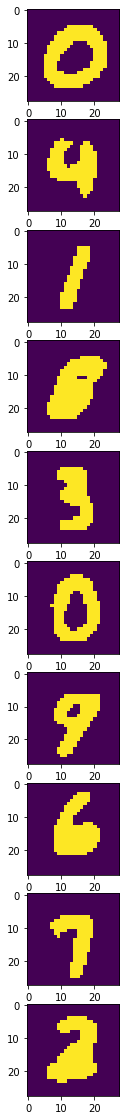

In [30]:
mu[mu > thr] = 1
mu[mu < thr] = 0
fig, ax = plt.subplots(len(mu), 1, figsize = (len(mu) * 20, 20))
for i, v in enumerate(mu):
    ax[i].imshow(v.reshape(28, 28))

In [31]:
mu.shape

(10, 784)

In [32]:
pi

array([0.05742824, 0.10932511, 0.10998957, 0.12440138, 0.14746416,
       0.0303288 , 0.13309787, 0.08423767, 0.09836204, 0.10536515])

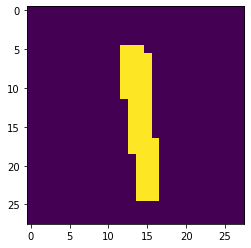

In [33]:
plt.imshow(X_train[8])

In [34]:
gamma = E_step(np.array([X_train.reshape(-1, 28*28)[8]]), pi, mu)

	Define log(g_c_i)
	Define gamma


In [35]:
new_pi, new_mu = M_step(np.array([X_train.reshape(-1, 28*28)[8]]), gamma)

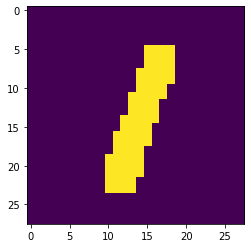

In [36]:
pred = mu[np.argmax(new_pi)].reshape(28, 28)
pred[pred >= thr] = 1
pred[pred < thr] = 0
plt.imshow(pred)